# Image Denoising with Diffusion Filter

This notebook implements a homogeneous, two-dimensional diffusion equation for image denoising.


## Imports and Setup

Import the scientific Python stack and configure Matplotlib for image display.


In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "gray"


## Image Denoising with Diffusion Filter

Implementation of a **homogeneous, two-dimensional diffusion equation** on a noisy image for denoising.

The diffusion equation is:
```
∂u/∂t = c·∇²u
```

We discretize this using finite differences on a uniform grid.


### Loading and Visualizing the Noisy Image

The noisy image is given as a density matrix in `noise.csv` (provided in the supplement).
I load it into a 2D NumPy array `u0` and plot it as a grayscale image to see what we are starting with.


Matrix shape: (100, 100)


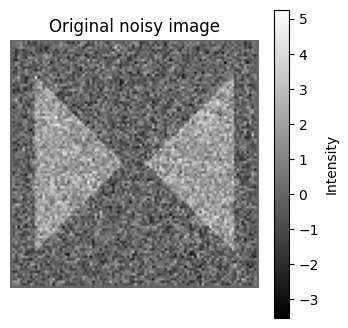

In [29]:
noise_path = "../data/noise.csv"

u0 = np.loadtxt(noise_path, delimiter=",")
print("Matrix shape:", u0.shape)

plt.figure(figsize=(4, 4))
plt.imshow(u0)
plt.colorbar(label="Intensity")
plt.title("Original noisy image")
plt.axis("off")
plt.show()


### Implementing one diffusion step (explicit scheme)

I now implement a single explicit diffusion step that applies the update rule from Eq. (1) to all
interior pixels. For an interior pixel at indices $$\((i,j)\)$$ the update is
$$
\[
u_{i,j}^{(t+\Delta t)} =
k \big( u_{i+1,j}^{(t)} + u_{i-1,j}^{(t)} + u_{i,j+1}^{(t)} + u_{i,j-1}^{(t)} \big)
+ (1 - 4k) u_{i,j}^{(t)},
\]$$

which is exactly Eq. (1) written in matrix index notation. The border values are simply copied from
the previous time point, so they stay constant during the diffusion.

I implement this in a **vectorized** way using NumPy slices instead of explicit Python `for` loops
over all pixels, because that is much faster for large matrices.


In [30]:
def diffusion_step(u: np.ndarray, k: float) -> np.ndarray:
    """Perform one explicit diffusion step on a 2D image u.

    Parameters
    ----------
    u : np.ndarray
        2D array (image) at time t.
    k : float
        Diffusion coefficient k = c * dt / h**2.

    Returns
    -------
    u_new : np.ndarray
        2D array after one time step (t + dt).
    """
    u = np.asarray(u, dtype=float)
    u_new = u.copy()

    center = u[1:-1, 1:-1]
    up     = u[0:-2, 1:-1]
    down   = u[2:  , 1:-1]
    left   = u[1:-1, 0:-2]
    right  = u[1:-1, 2:  ]

    u_new[1:-1, 1:-1] = k * (up + down + left + right) + (1.0 - 4.0 * k) * center

    u_new[0, :]  = u[0, :]
    u_new[-1, :] = u[-1, :]
    u_new[:, 0]  = u[:, 0]
    u_new[:, -1] = u[:, -1]

    return u_new


### Efficient helper: run diffusion once and keep selected snapshots

Instead of re-running the diffusion from scratch for every different number of time steps, I wrote
a small helper function `run_diffusion`. It takes

- the initial image `u0`,
- the diffusion coefficient `k`,
- and a list of **candidate step counts** that I am interested in.

It then:

1. Finds the **maximum** of those candidate steps.
2. Runs the diffusion once from step 1 up to that maximum.
3. Whenever the current step number is in the candidate list, it stores a copy of the image.
4. Returns a dictionary that maps each requested step number to the corresponding diffused image.

This way I only pay the cost of 2000 diffusion steps once (for the largest candidate) and then I can
re-use the intermediate results for all smaller step counts.


In [31]:
def run_diffusion(u0: np.ndarray, k: float, candidate_steps) -> dict:
    """Run diffusion up to max(candidate_steps) and return snapshots.

    Parameters
    ----------
    u0 : np.ndarray
        Initial image at time t=0.
    k : float
        Diffusion coefficient k = c * dt / h**2.
    candidate_steps : iterable of int
        Time steps (number of iterations) at which to store a copy of the image.
        If 0 is included, the original image is also returned.

    Returns
    -------
    results : dict[int, np.ndarray]
        Dictionary mapping each requested step count to the corresponding image.
    """
    candidate_steps = sorted({int(s) for s in candidate_steps if int(s) >= 0})
    if not candidate_steps:
        raise ValueError("candidate_steps must contain at least one non-negative integer")

    max_steps = max(candidate_steps)
    u = u0.copy()
    results: dict[int, np.ndarray] = {}

    if 0 in candidate_steps:
        results[0] = u.copy()

    for step in range(1, max_steps + 1):
        u = diffusion_step(u, k)
        if step in candidate_steps:
            results[step] = u.copy()

    return results


### Exploring different numbers of time steps (dt = 0.1, k = 0.1)

The parameters to use coordinate spacing **`h = 1.0`** and time spacing
**`dt = 0.1`**. With **`c = 1.0`** this gives **`k = 0.1`** via
$$\(k = c\,\Delta t / h^2 = 1.0 \cdot 0.1 / 1.0^2 = 0.1\)$$.

To get a feeling for the dynamics, I do not immediately pick a single number of time steps. Instead
I try a *set* of candidates

```python
candidate_steps = [5, 10, 25, 50, 100, 150, 200, 2000]
```

and use my `run_diffusion` helper to compute all of them in one go. This produces a nice panel
showing how the image evolves as I diffuse longer and longer.


h = 1.0, dt = 0.1, c = 1.0, k = 0.1


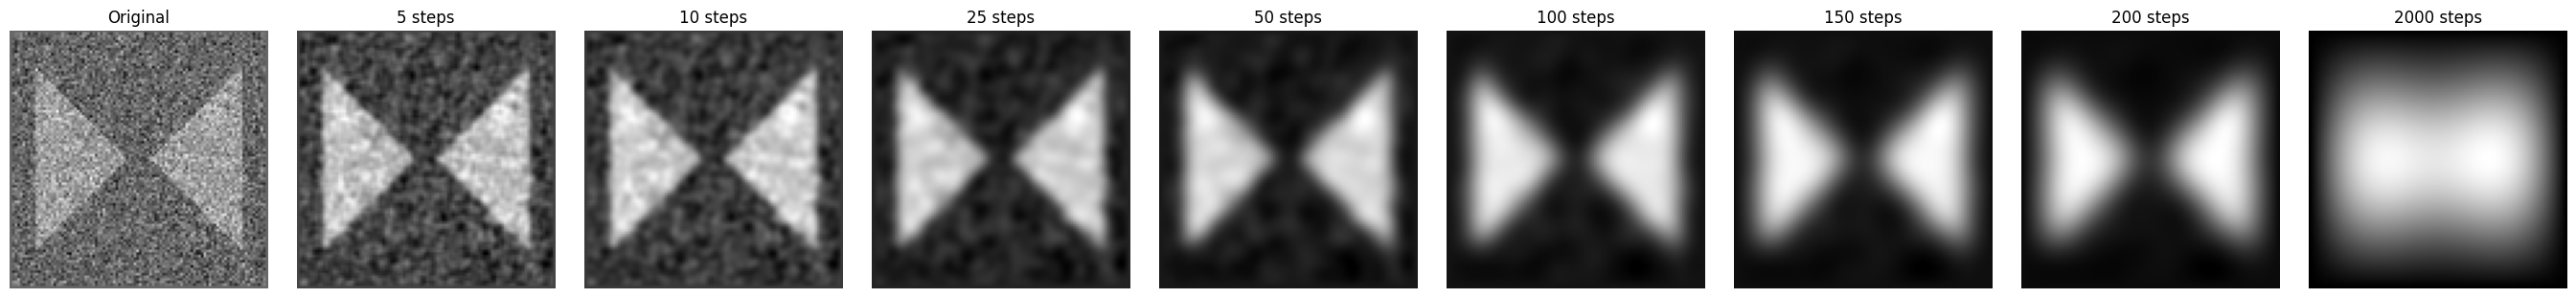

In [32]:
h = 1.0
dt = 0.1
c = 1.0
k = c * dt / (h ** 2)
print(f"h = {h}, dt = {dt}, c = {c}, k = {k}")

candidate_steps = [5, 10, 25, 50, 100, 150, 200, 2000]

snapshots = run_diffusion(u0, k, candidate_steps)

fig, axes = plt.subplots(1, len(candidate_steps) + 1,
                         figsize=(3 * (len(candidate_steps) + 1), 3),
                         constrained_layout=True)

axes[0].imshow(u0)
axes[0].set_title("Original")
axes[0].axis("off")

for ax, n in zip(axes[1:], candidate_steps):
    ax.imshow(snapshots[n])
    ax.set_title(f"{n} steps")
    ax.axis("off")

plt.show()


#### Observations from the step panel

From left to right I am looking at the original noisy image and the diffused images after
**5, 10, 25, 50, 100, 150, 200, and 2000 time steps** with `dt = 0.1` and `k = 0.1`.

- After **5** and **10** steps the random salt-and-pepper noise is already clearly reduced, but the
  background is still quite grainy.
- Around **25** steps the two bright triangular shapes are nicely visible and most of the small
  pixel-level noise has disappeared, but there is still some texture left in the background.
- At **50** steps the structure of the two triangles is very clear: the edges are still
  reasonably sharp, the center gap is visible, and the background looks smooth without being
  completely flat.
- At **100**, **150**, and **200** steps I can see that the triangles start to become thicker and
  slightly more blurred; the image is still recognisable, but the fine shape details are slowly
  washed out.
- At **2000** steps the whole image is basically a smooth "blob" with almost no structural
  information left – this is what I would expect if I diffuse for a very long time: everything
  converges towards something close to a constant.

Based on this visual inspection, the **"sweet spot"** for this data (with `h = 1.0`, `dt = 0.1`,
and `k = 0.1`) seems to be somewhere around **25–50 steps**. Fewer steps do not remove enough noise,
while more steps start to noticeably deform and blur the underlying shape.


### Choosing the Optimal Number of Diffusion Steps

From the candidate panel I decided to fix

- **`n_steps_best = 50`**

for the main before/after comparison. With my parameters `dt = 0.1` and `k = 0.1`, this means
a total diffusion time of
$$
\[
T_{\text{final}} = n_{\text{steps\_best}} \cdot \Delta t = 50 \cdot 0.1 = 5.0,
\]
$$
so I am effectively diffusing the image for a "time" of **`T_final = 5.0`** in the units of the
discrete scheme.

Below I re-use `run_diffusion` to get only the snapshot for **50 steps** and compare it directly to
    the original noisy image.


Using n_steps_best = 50, dt = 0.1, so T_final = 5.0


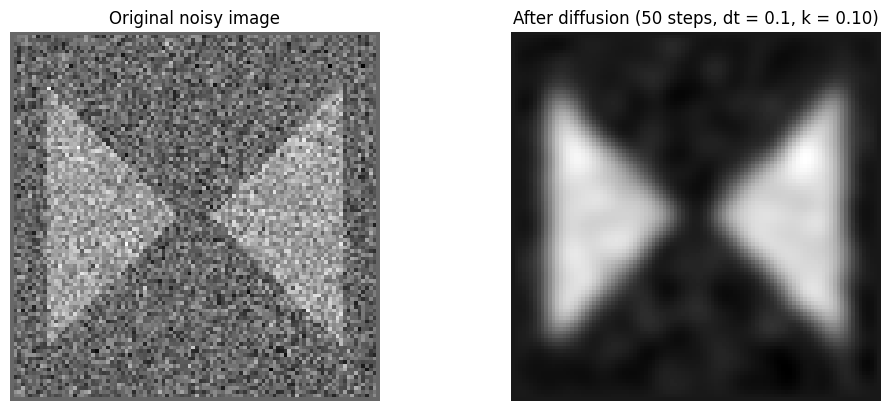

In [33]:
n_steps_best = 50
T_final = n_steps_best * dt
print(f"Using n_steps_best = {n_steps_best}, dt = {dt}, so T_final = {T_final}")

best_snapshot_dict = run_diffusion(u0, k, [n_steps_best])
u_best = best_snapshot_dict[n_steps_best]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

axes[0].imshow(u0)
axes[0].set_title("Original noisy image")
axes[0].axis("off")

axes[1].imshow(u_best)
axes[1].set_title(f"After diffusion ({n_steps_best} steps, dt = {dt}, k = {k:.2f})")
axes[1].axis("off")

plt.show()


#### Explanation of my choice `n_steps_best = 50`

With **`n_steps_best = 50`**, **`dt = 0.1`**, and **`k = 0.1`**, the result looks like a very good
compromise between denoising and preserving the shape:

- The **random noise** that dominated the original `noise.csv` matrix is largely gone.
- The two bright **triangular regions** are clearly visible, and their boundaries are still
  reasonably sharp. The gap between them in the middle is clean.
- The **background** is smooth and no longer distracts from the actual structure.

For comparison:

- At **10 steps** (`dt = 0.1`, `k = 0.1`) there is still a noticeable amount of graininess, especially
  in the background.
- At **100 steps** and above, the triangles start to thicken and blur, and at **200 steps** and
  especially **2000 steps** the image approaches a very smooth blob where I lose most of the
  details of the bow-tie shape.

So for this particular image and parameter set I would argue that **50 steps** hits a nice sweet spot:
it removes the noise enough to reveal the structure, but does not yet destroy the structure by
over-smoothing it.


### Exploring Different Time Steps (dt = 0.25 and dt = 0.4)

In this section, I keep the **spatial spacing** fixed at `h = 1.0` but change the **time step** `dt` to
**0.25** and **0.4**. The diffusion coefficient is
$$
\[
k = \frac{c\,\Delta t}{h^2},\quad c = 1.0,\; h = 1.0,
\]
$$
so for the three time step sizes I get

- `dt = 0.1`  \(\Rightarrow k = 0.1\),
- `dt = 0.25` \(\Rightarrow k = 0.25\),
- `dt = 0.4`  \(\Rightarrow k = 0.4\).

To make the comparison fair, I try to keep the **total diffusion time** approximately constant at
the value used previously, namely **`T_final = 5.0`**. For each `dt` I pick
$$
\[
n_{\text{steps}} \approx \frac{T_{\text{final}}}{\Delta t}.
\]
$$
Concretely, this gives me:

- For `dt = 0.1`:   `n_steps = 50`  (this is the baseline setting),
- For `dt = 0.25`:  `n_steps = 20`  (since 5.0 / 0.25 = 20),
- For `dt = 0.4`:   `n_steps = 12`  (since 5.0 / 0.4 = 12.5, which I round to 12).

Below I compute and plot all three results next to each other and compare them.


dt = 0.10 -> k = 0.10, n_steps = 50
dt = 0.25 -> k = 0.25, n_steps = 20
dt = 0.40 -> k = 0.40, n_steps = 12


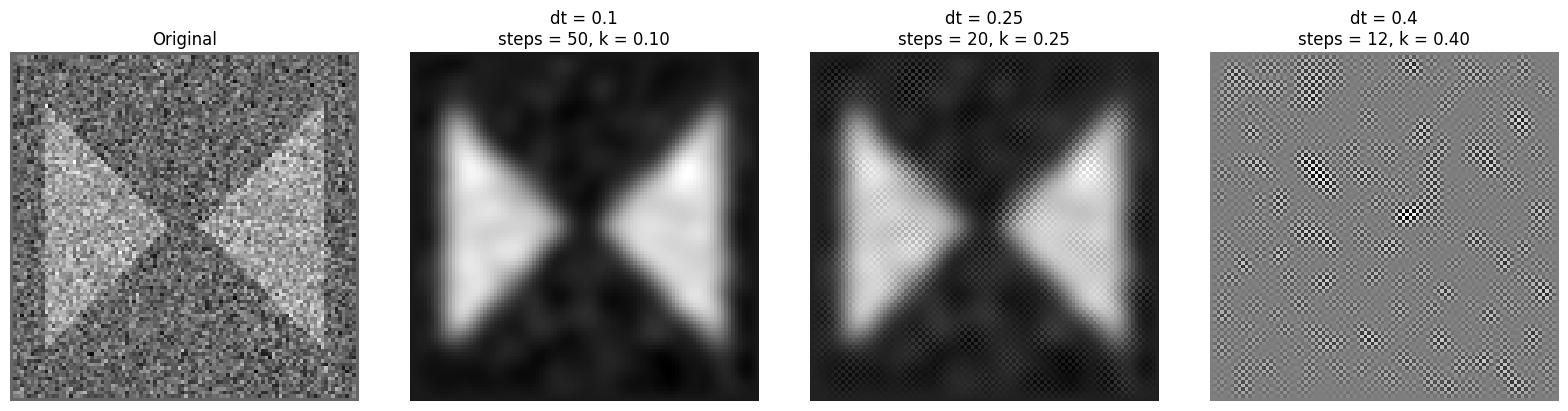

In [34]:
dt_values = [0.1, 0.25, 0.4]
T_target = T_final

results_part_b = []

for dt_b in dt_values:
    k_b = c * dt_b / (h ** 2)
    n_steps_b = int(round(T_target / dt_b))
    print(f"dt = {dt_b:.2f} -> k = {k_b:.2f}, n_steps = {n_steps_b}")

    snap_b = run_diffusion(u0, k_b, [n_steps_b])
    u_b = snap_b[n_steps_b]
    results_part_b.append((dt_b, n_steps_b, k_b, u_b))

fig, axes = plt.subplots(1, len(results_part_b) + 1,
                         figsize=(4 * (len(results_part_b) + 1), 4),
                         constrained_layout=True)

axes[0].imshow(u0)
axes[0].set_title("Original")
axes[0].axis("off")

for ax, (dt_b, n_steps_b, k_b, u_b) in zip(axes[1:], results_part_b):
    ax.imshow(u_b)
    ax.set_title(f"dt = {dt_b}\nsteps = {n_steps_b}, k = {k_b:.2f}")
    ax.axis("off")

plt.show()


#### How the result changes when I change `dt` and why

From the plot above I can compare the three settings:

1. **`dt = 0.1`, `k = 0.10`, `n_steps = 50`**  
   This is the baseline configuration. The result looks well-behaved: the
   triangles are smooth, the noise is strongly reduced, and there are no obvious numerical
   artifacts.

2. **`dt = 0.25`, `k = 0.25`, `n_steps = 20`**  
   Here the diffusion per step is stronger: `k` increases from 0.10 to 0.25. Visually the image is
   noticeably more blurred compared to the `dt = 0.1` case. I can still recognize the two triangles,
   but their boundaries are softer and the background is more washed out. In my run I also start to
   see a faint **checkerboard pattern**, especially in the darker regions. This makes sense, because
   for `k = 0.25` we have `1 - 4k = 0`, so each pixel becomes more or less the average of its four
   neighbors, which is right at the edge of the usual stability condition for this explicit scheme.

3. **`dt = 0.4`, `k = 0.40`, `n_steps = 12`**  
   Now the situation changes completely. With `k = 0.40` we get `1 - 4k = 1 - 1.6 = -0.6`, so the
   weight of the center pixel in the update becomes **negative**. In the resulting image the actual
   bow-tie structure is basically gone, and the whole matrix is dominated by a strong, high-frequency
   **checkerboard artifact**. This is exactly what I would expect when the explicit diffusion scheme
   is pushed beyond its stability limit: instead of smoothing, the solution starts to oscillate and
   blow up in alternating patterns.

So to summarise:

- Increasing `dt` from **0.1** to **0.25** (with `h = 1.0` and `c = 1.0`) increases `k` from **0.10**
  to **0.25**. This leads to stronger smoothing per step and slightly more blurring, but the method
  is still just about stable.
- Increasing `dt` further to **0.4** makes `k = 0.40`, which violates the usual stability bound
  \(k \le 0.25\) for this explicit discretization. In my experiment this immediately shows up as a
  checkerboard pattern and a complete loss of the actual image structure.

This explains why simply making `dt` larger is dangerous here: it is tempting to take fewer steps,
but beyond a certain point (`k > 0.25` in this setup) the scheme no longer behaves like diffusion
and instead produces numerical artifacts.


### Why the Diffusion Equation is Suitable for Denoising

The diffusion equation is basically a **smoothing operator**. In the discrete form I used here,
every update replaces a pixel value by a weighted combination of its four neighbors and its own
previous value. For the baseline parameters (`dt = 0.1`, `h = 1.0`, `c = 1.0`, `k = 0.1`), each
pixel is pulled towards the average of its neighborhood while still keeping some contribution from
its old value.

This is exactly what we want for denoising:

- **Random noise** usually changes very quickly from pixel to pixel, so averaging in a local
  neighborhood cancels it out quite efficiently.
- **Meaningful structures** (like the triangles in the `noise.csv` image) vary more slowly in space,
  so they survive a moderate amount of diffusion.

In the context of **automated image analysis**, having a denoised image is important because many
downstream tasks (segmentation, edge detection, shape measurement, etc.) become much more robust
when the input is not dominated by high-frequency noise. In my case, the diffused image after
**50 steps** (`n_steps_best = 50`, `dt = 0.1`, `k = 0.1`) shows a very clean bow-tie shape that would
be much easier to threshold or segment than the original noisy matrix.

However, it **does matter** how long I apply the diffusion:

- For a **small to moderate** number of steps, like **25–50** in my experiments, the noise is reduced
  and the underlying structure is still preserved.
- For a **large** number of steps, such as **200** or even **2000** with `dt = 0.1`, the solution
  becomes extremely smooth and eventually approaches something close to a uniform field. In the
  extreme case (2000 steps) almost all contrast is gone and the triangles are basically invisible.

So the diffusion equation is a very natural tool for image denoising, but it needs to be applied
for a **carefully chosen duration**. My experiments with `n_steps_best = 50` illustrate this trade-off
quite nicely: too few steps leave too much noise, too many steps destroy the image content, and
somewhere in the middle (here: 50 steps, total diffusion time `T_final = 5.0`) I get a clean and
still interpretable result.
